In [4]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

El primer paso sera importar el CSV con los datos a un DataFrame de pandas para poder observarlo y definir los pasos a seguir.

In [5]:
df = pd.read_csv("AccidentesAviones.csv")

In [6]:
df

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,5003,"March 28, 2021",1835,"Near Butte, Alaska",Soloy Helicopters,?,Sightseeing Charter,Eurocopter AS350B3 Ecureuil,N351SH,4598,6,5,1,5,4,1,0,The sightseeing helicopter crashed after missi...
5004,5004,"May 21, 2021",1800,"Near Kaduna, Nigeria",Military - Nigerian Air Force,?,?,Beechcraft B300 King Air 350i,NAF203,FL-891,11,7,4,11,7,4,0,"While on final approach, in poor weather condi..."
5005,5005,"June 10, 2021",0800,"Near Pyin Oo Lwin, Myanmar",Military - Myanmar Air Force,?,Naypyidaw - Anisakan,Beechcraft 1900D,4610,E-325,14,12,2,12,11,1,0,The plane was carrying military personnel and ...
5006,5006,"July 04, 2021",11:30,"Patikul, Sulu, Philippines",Military - Philippine Air Force,?,Cagayan de Oro-Lumbia - Jolo,Lockheed C-130H Hercules,5125,5125,96,88,8,50,?,?,3,"While attempting to land at Jolo Airport, the ..."


In [7]:
df.dtypes

Unnamed: 0                 int64
fecha                     object
HORA declarada            object
Ruta                      object
OperadOR                  object
flight_no                 object
route                     object
ac_type                   object
registration              object
cn_ln                     object
all_aboard                object
PASAJEROS A BORDO         object
crew_aboard               object
cantidad de fallecidos    object
passenger_fatalities      object
crew_fatalities           object
ground                    object
summary                   object
dtype: object

Haciendo una primera inspeccion de los datos, se ven varios problemas generales de la tabla:
- no unanimidad de idiomas en los nombres de las columnas
- no esta claro el contenido de algunas columnas
- hay valores faltantes
- no hay uniformidad de formatos en algunas columnas

Por lo tanto, procederemos a realizar una inspeccion mas minuciosa, columna por columna para intentar resolver estos problemas.

# Columna 'Unnamed'

In [8]:
df['Unnamed: 0'].nunique()

5008

Al ver que coinciden los valores unicos de la columna con la cantidad total de filas, esta columna podria ser el indice o identificador de casos.

In [9]:
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

# Columna 'fecha'

In [10]:
df['fecha'].value_counts()

fecha
August 31, 1988       4
September 11, 2001    4
February 23, 1945     3
December 28, 1946     3
August 27, 1992       3
                     ..
December 04, 1958     1
December 23, 1958     1
December 24, 1958     1
December 26, 1958     1
July 06, 2021         1
Name: count, Length: 4577, dtype: int64

Corresponde a la fecha del accidente pero se encuentra en un formato inconveniente para realizar consultas, por lo tanto los vamos a convertir al formato 'datetime'

In [11]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['fecha']

0      1908-09-17
1      1909-09-07
2      1912-07-12
3      1913-08-06
4      1913-09-09
          ...    
5003   2021-03-28
5004   2021-05-21
5005   2021-06-10
5006   2021-07-04
5007   2021-07-06
Name: fecha, Length: 5008, dtype: datetime64[ns]

Ademas, para facilitar el analisis, crearemos dos columnas: 'año' y 'decada' que eventualmente permitiran agrupar los casos.

In [12]:
df['año'] = df.apply(lambda f: f['fecha'].year, axis=1)

df['decada'] = df.apply(lambda f: (f['fecha'].year // 10) * 10, axis=1)

# Columna 'HORA declarada'

In [13]:
df['HORA declarada'].value_counts()

HORA declarada
?       1504
1500      35
1400      30
1100      30
1700      29
        ... 
2129       1
1002       1
1151       1
0909       1
1914       1
Name: count, Length: 1217, dtype: int64

Corresponde a la hora del accidente y hay varios problemas:
- diferencias de formato
- datos faltantes (30% de la columna) que no figuran como nulos, sino como '?'
- no se aclara que zona horaria se toma.

Respecto a este ultimo punto, investigando acerca de 2 de los accidentes listado, encuentro que la hora corresponde a la local, por lo tanto, asumo que el resto de los datos mantienen el criterio.

In [14]:
df.rename(columns={'HORA declarada': 'hora_decl'}, inplace= True)

In [15]:
def formatear_hora(hora):
    # Defino una funcion para unificar el formato de la hora que recibe un valor y lo convierte al formato hhmm.
    # Los valores nulos que se encuentran registrados como '?' son convertidos a NaN.
    hora = str(hora)
    resultado = re.search("(\d{2}):?(\d{2})", hora)
    if resultado is not None:
        return str(resultado.group(1) + resultado.group(2))
    elif hora == '?':
        return np.nan

In [16]:
df['hora_decl'] = df.apply(lambda f: formatear_hora(f['hora_decl']), axis=1)

Queda pendiente definir que hacer con los valores nulos. Una opcion podria ser buscarlos en la informacion de la columna 'summary'. Pero al ser tantos, se vuelve un esfuerzo muy grande para un dato del que no conocemos aun su relevancia en el analisis.

# Columna 'Ruta'

In [17]:
df['Ruta'].value_counts()

Ruta
Moscow, Russia                                         16
Manila, Philippines                                    15
New York, New York                                     14
Sao Paulo, Brazil                                      13
Cairo, Egypt                                           13
                                                       ..
NAS Argentia, Placentia Bay,  Newfoundland,  Canada     1
Anzio, Italy                                            1
Nipe Bay, Cuba                                          1
Near Roccatamburo di Poggiodomo, Italy                  1
Palana, Russia                                          1
Name: count, Length: 4125, dtype: int64

En primera instancia no se entiende a que corresponde este dato, podria ser el origen o el destino del vuelo.
Realizando una investigacion mas exhaustiva de algunos casos, encuentro que coincide con el lugar del accidente, que en algunos casos coincide con el origen o el destino y en otros no. Por lo tanto, renombro la columna.

In [18]:
df.rename(columns={'Ruta': 'lugar_accidente'}, inplace= True)

Chequeo la presencia de valores faltantes y, al ser pocos, los analizo uno a uno.

In [19]:
df.loc[df['lugar_accidente'] == '?']

,id,fecha,hora_decl,lugar_accidente,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary,año,decada
360,360,1934-12-31,NaN,?,Aeroflot,?,?,Tupolev ANT-9,?,?,10,8,2,10,8,2,0,Crashed under unknown circumstances.,1934,1930
465,465,1937-06-20,NaN,?,ENTA,?,San José San Isidro de El General,Travel Air 6000,TI-3,?,6,5,1,6,5,1,?,Hit trees and crashed in an isolated area loca...,1937,1930
646,646,1942-08-21,NaN,?,Deutsche Lufthansa,?,?,Siebel Si-204,?,?,4,2,2,4,2,2,0,"Lufthansa chairman, Von Gablenz killed.",1942,1940
999,999,1947-11-27,NaN,?,China National Aviation Corporation,?,?,Douglas DC-3,?,?,3,0,3,2,0,2,0,The cargo plane was shot down by communist ant...,1947,1940
2895,2895,1977-01-20,NaN,?,North Canada Air,?,?,Bristol 170 Freighter 31M,C-FWAD,13253,2,0,2,1,0,1,0,The cargo plane stalled nearly vertical and cr...,1977,1970


Para el id 465, encuentro en la columna 'summary' que el lugar del accidente es Cerro las vueltas, San Jose, Costa Rica.

Para el resto de los valores faltantes, las otras columnas no aportan informacion relevante.

In [20]:
df.loc[df['id'] == 465, ['lugar_accidente']] = 'Cerro las vueltas, San Jose, Costa Rica'

In [21]:
df['lugar_accidente'].replace('?', np.nan, inplace=True)

# Columna 'OperadOR'

In [22]:
df['OperadOR'].value_counts()

OperadOR
Aeroflot                            253
Military - U.S. Air Force           141
Air France                           74
Deutsche Lufthansa                   63
United Air Lines                     44
                                   ... 
Sierra Pacific Airlines               1
Pathet Lao Airlines                   1
Military - West German Air Force      1
Cessnyca                              1
Kamchatka Aviation Enterprise         1
Name: count, Length: 2268, dtype: int64

Corresponde a la empresa operadora del vuelo. Cambio el nombre de la columna.

In [23]:
df.rename(columns={'OperadOR': 'empresa_operadora'}, inplace= True)

In [24]:
df['empresa_operadora'].value_counts()['?']

10

Chequeo la presencia de valores faltantes y, al ser pocos, los reviso uno a uno.

In [25]:
df.loc[df['empresa_operadora'] == '?']

,id,fecha,hora_decl,lugar_accidente,empresa_operadora,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary,año,decada
1,1,1909-09-07,NaN,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...,1909,1900
17,17,1917-06-17,NaN,"Near Yarmouth, England",?,?,?,Zepplin L-48 (air ship),L-48,?,16,?,?,14,?,?,0,Shot down by aircraft.,1917,1910
67,67,1922-04-08,NaN,"Pao Ting Fou, China",?,?,Test,?,?,?,17,0,17,17,0,17,0,Aboard were all workers taking part in a fligh...,1922,1920
69,69,1922-07-04,NaN,"Fuhlsbuttel, Germany",?,?,Hamburg - Berlin,LVG C VI,?,?,3,2,1,2,1,1,0,The passenger/mail plane lost it's engine whil...,1922,1920
114,114,1926-09-26,NaN,"New York, New York",?,?,New York - Paris,Sikorsky S-25,?,?,5,4,1,2,2,0,0,Too much weight caused the landing gear to col...,1926,1920
376,376,1935-05-29,NaN,"San Barbra, Honduras",?,?,?,?,?,?,9,?,?,6,?,?,0,Crashed into the Ulua River.,1935,1930
684,684,1943-07-04,2300,Gibraltar,?,?,?,Consolidated Liberator B24 C,A-L-523,?,13,?,?,12,?,?,0,"The flight, bound for London, crashed into the...",1943,1940
859,859,1946-04-08,NaN,"Near Shensi, China",?,?,Shensi - Yenan,?,?,?,14,11,3,14,11,3,0,?,1946,1940
2061,2061,1963-09-02,NaN,Northeast Laos,?,?,?,Curtiss C-46 Commando,?,?,16,13,3,15,12,3,?,Refugee flight.,1963,1960
4830,4830,2011-12-26,0554,"Green Grove, Florida",?,?,"Jacksonville, FL - Gainsville, FL",Bell 206B,N5016M,2636,3,2,1,3,2,1,0,The on-demand air taxi was on a flight to proc...,2011,2010


Las otras columanas no brindan informacion relevante para los valores faltantes, los asigno como NaN.

In [26]:
df['empresa_operadora'].replace('?', np.nan, inplace=True)

# Columna 'flight_no'

In [27]:
df['flight_no'].value_counts()

flight_no
?        3682
-          36
1          11
101         9
6           7
         ... 
138         1
124         1
1-10        1
4422        1
SJ182       1
Name: count, Length: 893, dtype: int64

El dato corresponde al numero de vuelo.

Encontramos muchos valores faltantes, esto podria deberse a que probablemente los vuelos mas antiguos registrados no tuvieran asignado un numero de vuelo.
Cambio el nombre de la columna y designo a los faltantes como NaN.

In [28]:
df['flight_no'].replace('?', np.nan, inplace=True)

In [29]:
df.rename(columns={'flight_no': 'nro_vuelo'}, inplace= True)

# Columna 'route'

In [30]:
df['route'].value_counts()

route
?                                       762
Training                                 96
Sightseeing                              31
Test flight                              23
Sao Paulo - Rio de Janeiro                7
                                       ... 
Prague - Zurich                           1
Temuco - Santiago                         1
Hong Kong - Tainan AFB                    1
Fort Lamy, Chad - Marseilles, France      1
Petropavlovsk - Palana                    1
Name: count, Length: 3838, dtype: int64

El dato corresponde a la ruta del vuelo, con origen y destino separados con un guion. Cuando corresponden a paises diferentes, estan en formato 'ciudad de origen, pais de origen - ciudad de destino, pais de destino'.
Esto podria estar en dos columnas: una de origen y otra de destino.
Por otro lado, algunos vuelos no poseen una ruta y en su lugar indican el objetivo del vuelo (por ejemplo, 'Test flight' o 'Demostration'). En ese caso, este dato no deberia estar en esta columna sino en otra.
Ademas, hay valores faltantes, que podrian deberse a vuelos sin ruta como los mencionados en el item anterior.

In [31]:
df['route'].replace('?', np.nan, inplace=True)

In [32]:
df.rename(columns={'route': 'origen-destino'}, inplace= True)

# Columna 'ac_type'

In [33]:
df['ac_type'].value_counts()

ac_type
Douglas DC-3                                333
de Havilland Canada DHC-6 Twin Otter 300     81
Douglas C-47A                                70
Douglas C-47                                 64
Douglas DC-4                                 41
                                           ... 
Vickers Viscount 759D                         1
H-21B                                         1
Avro 685 York C1                              1
Piper PA-24-250 Comanche                      1
Antonov An 26B-100                            1
Name: count, Length: 2469, dtype: int64

El dato corresponde al tipo de aeronave. cambio el nombre de la columna y defino como Nan los valores faltantes.

In [34]:
df.rename(columns={'ac_type': 'tipo_aeronave'}, inplace= True)

In [35]:
df['tipo_aeronave'].replace('?', np.nan, inplace=True)

# Columna 'registration'

In [36]:
df['registration'].value_counts()

registration
?             272
49              3
SU-AFK          2
2               2
19              2
             ... 
CCCP-61663      1
EC-ANR          1
N1301N          1
CS-THB          1
RA-26085        1
Name: count, Length: 4701, dtype: int64

Corresponde al numero de registro o matricula de la aeronave. Cambio el nombre de la columna y defino como Nan los valores  faltantes.

In [37]:
df['registration'].replace('?', np.nan, inplace=True)

In [38]:
df.rename(columns={'registration': 'matricula_aeronave'}, inplace= True)
df.head(1)

,id,fecha,hora_decl,lugar_accidente,empresa_operadora,nro_vuelo,origen-destino,tipo_aeronave,matricula_aeronave,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary,año,decada
0,0,1908-09-17,1718,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly...",1908,1900


# Columna 'cn_ln'

In [39]:
df['cn_ln'].value_counts()

cn_ln
?        667
1          8
4          8
125        7
229        6
        ... 
068        1
1142       1
43559      1
10182      1
12310      1
Name: count, Length: 3908, dtype: int64

Corresponde al numero de construccion ("construction number" en ingles, o "cn") y al numero de linea ("line number", o "ln"). Son identificadores del modelo de aeronave y su fabricacion.
Cambio el nomnbre de la columna y defino como Nan los valores faltantes.

In [40]:
df['cn_ln'].replace('?', np.nan, inplace=True)

In [41]:
df.rename(columns={'cn_ln': 'nc_nl'}, inplace= True)

# Columnas 'all_aboard', 'PASAJEROS A BORDO' Y 'crew_aboard'

In [42]:
df['all_aboard'].value_counts()

all_aboard
3      280
2      246
4      202
5      190
10     179
      ... 
256      1
524      1
329      1
274      1
190      1
Name: count, Length: 245, dtype: int64

Corresponde al total de personas a bordo. Deberia corresponder a la suma de las columnas 'PASAJEROS A BORDO' y 'crew' a bordo. Utilizaremos estos datos para imputar los faltantes en caso que se pueda.

In [43]:
df.rename(columns={'all_aboard': 'total_a_bordo'}, inplace= True)

In [44]:
df.rename(columns={'PASAJEROS A BORDO': 'pasajeros', 'crew_aboard': 'tripulacion'}, inplace= True)

In [45]:
df.loc[df['tripulacion'] == '?']

,id,fecha,hora_decl,lugar_accidente,empresa_operadora,nro_vuelo,origen-destino,tipo_aeronave,matricula_aeronave,nc_nl,total_a_bordo,pasajeros,tripulacion,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary,año,decada
4,4,1913-09-09,1830,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...,1913,1910
5,5,1913-10-17,1030,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,28,?,?,28,?,?,0,Hydrogen gas which was being vented was sucked...,1913,1910
7,7,1915-09-03,1520,"Off Cuxhaven, Germany",Military - German Navy,NaN,NaN,Zeppelin L-10 (airship),NaN,NaN,19,?,?,19,?,?,0,"Exploded and burned near Neuwerk Island, when...",1915,1910
8,8,1916-07-28,NaN,"Near Jambol, Bulgeria",Military - German Army,NaN,NaN,Schutte-Lanz S-L-10 (airship),NaN,NaN,20,?,?,20,?,?,0,"Crashed near the Black Sea, cause unknown.",1916,1910
9,9,1916-09-24,0100,"Billericay, England",Military - German Navy,NaN,NaN,Zeppelin L-32 (airship),NaN,NaN,22,?,?,22,?,?,0,Shot down by British aircraft crashing in flames.,1916,1910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,4791,2010-11-25,1207,"Strezhevoy, Russia",NARZ,NaN,NaN,Mil Mi-8T,RA-22376,7257,10,?,?,7,?,?,0,"The helicopter, which was delivering workers t...",2010,2010
4802,4802,2011-04-19,1357,"Tawang, India",Pawan Hans Helicopters Ltd.,NaN,NaN,Mil Mi-172,VT-PHF,356C06,23,?,?,18,?,?,0,The helicopter crashed into a hill as it attem...,2011,2010
4813,4813,2011-08-06,NaN,"Tangi Valley, Afghanistan",Military - U.S. Army,NaN,NaN,Boeing CH-47 Chinook,NaN,NaN,38,?,?,38,?,?,0,"Thirty-eight people, including 31 U.S. special...",2011,2010
4833,4833,2012-03-16,1045,"Kabul, Afghanistan",Military - Turkish Army (NATO),NaN,NaN,Sikorsky S-70A-28,10981,NaN,12,?,?,12,?,?,4,The helicopter crashed on the outskirts of Kab...,2012,2010


In [46]:
df['total_a_bordo'].replace('?', np.nan, inplace=True)
df['total_a_bordo'] = pd.to_numeric(df['total_a_bordo'])


In [47]:
df['pasajeros'].replace('?', np.nan, inplace=True)
df['pasajeros'] = pd.to_numeric(df['pasajeros'])

df['tripulacion'].replace('?', np.nan, inplace=True)
df['tripulacion'] = pd.to_numeric(df['tripulacion'])


Reemplazo los valores faltantes '?' por Nan, para poder convertir las columnas a numericas.
Por otro lado, los faltantes son demasiados para verlos uno a uno por lo que procedo a analizarlos teniendo en cuenta:
- cuantos casos hay en los que todas estas columnas falten
- casos en los que los datos no son consistentes (el numero de tripulacion es 0, el numero de pasajeros o tripulacion es mayor al de total_a_bordo)

In [48]:
df = df.drop(df[df['total_a_bordo'] != df['pasajeros'] +
                    df['tripulacion']].index)

# Columnas 'cantidad de fallecidos', 'passenger_fatalities' y 'crew_fatalities'

In [49]:
df['cantidad de fallecidos'].value_counts()

cantidad de fallecidos
1      364
2      363
3      355
4      240
5      232
      ... 
259      1
144      1
171      1
223      1
224      1
Name: count, Length: 198, dtype: int64

Corresponde al total de personas fallecidas. Deberia corresponder a la suma de las columnas 'passangers_fatalities' y 'crew_fatalities'. Utilizaremos estos datos para imputar los faltantes en caso que se pueda.

In [50]:
df['passenger_fatalities'].value_counts()

passenger_fatalities
0      1030
1       298
2       261
3       192
4       185
       ... 
248       1
172       1
140       1
278       1
217       1
Name: count, Length: 191, dtype: int64

In [51]:
df['crew_fatalities'].value_counts()

crew_fatalities
2     883
3     822
1     765
4     590
5     400
0     393
6     272
7     170
8     128
9      85
10     68
11     41
12     24
14     23
13     22
?      18
15     11
17      6
23      6
16      5
22      5
19      5
20      3
18      3
25      2
21      2
43      1
27      1
33      1
Name: count, dtype: int64

In [52]:
df.rename(columns={'cantidad de fallecidos': 'total_fallecidos', 'crew_fatalities': 'tripulacion_fallecidos', 'passenger_fatalities': 'pasajeros_fallecidos'}, inplace= True)

Combio los nombres de las columnas y modifico los valores '?' por NaN

In [53]:
df['total_fallecidos'].replace('?', np.nan, inplace=True)
df['total_fallecidos'] = pd.to_numeric(df['total_fallecidos'])

df['tripulacion_fallecidos'].replace('?', np.nan, inplace=True)
df['tripulacion_fallecidos'] = pd.to_numeric(df['tripulacion_fallecidos'])

df['pasajeros_fallecidos'].replace('?', np.nan, inplace=True)
df['pasajeros_fallecidos'] = pd.to_numeric(df['pasajeros_fallecidos'])

Al igual que con las columnas total_a_bordo, pasajeros y tripulacion, busco incoherencias en los valores, ademas de valores faltantes: casos en que haya mas fallecidos que personas a bordo, por ejemplo.

In [54]:
df = df.drop(df[df['total_fallecidos'] != df['pasajeros_fallecidos'] +
                df['tripulacion_fallecidos']].index)

df = df.drop(df[df['pasajeros'] < df['pasajeros_fallecidos']].index)
df = df.drop(df[df['tripulacion'] < df['tripulacion_fallecidos']].index)
df = df.drop(df[df['tripulacion'] == 0].index)

# Columna 'ground'

In [55]:
df['ground'].value_counts()

ground
0       4446
1         60
2         34
?         27
3         20
4         15
5         11
7          9
8          9
6          6
10         5
22         4
11         4
13         4
19         4
14         4
44         3
24         3
125        2
20         2
12         2
30         2
25         2
2750       2
18         1
45         1
78         1
50         1
39         1
225        1
85         1
47         1
49         1
15         1
23         1
9          1
32         1
113        1
71         1
33         1
87         1
31         1
17         1
29         1
16         1
58         1
63         1
35         1
Name: count, dtype: int64

Este dato podria referirse a la cantidad de personas que se encontraban en el area de control en tierra. Al no haber mas informacion, es dificil de determinar su utilidad.

# Columna 'summary'

Esta columna es un resumen del evento. Posee informacion valiosa pero dificil de extraer, ya que precisariamos hacer procesamiento de lenguaje natural.
En principio, realizaremos un primer intento de extraer palabras clave utilizando una bolsa de palabras.

Obervando los resultados entregados para la nube de palabra, decido tomar tres categorias de palabras que considero que podrian ser relevantes para el analisis:
- Palabras relacionadas con la milicia: representarian accionar belico, no accidental, por lo que no serian relevantes para el analisis.
- Palabras relacionadas con el clima: indicarian que el accidente estaria relacionado con las condiciones climaticas.
- Palabras relacionadas con la pista: indicarian que el accidente estaria relacionado con el despegue o aterrizaje.

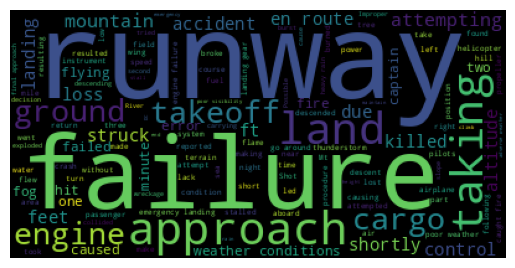

In [61]:
texto = df['summary'].str.cat(sep=' ')

sw = STOPWORDS.copy()
sw.update(['crashed', 'aircraft', 'plane', 'flight', 'pilot', 'crew', 'airport'])
wc = WordCloud(stopwords=sw)

wc.generate(texto)
plt.figure()
plt.imshow(wc)
plt.axis("off")
plt.show()

In [2]:
def contiene_palabras_clave(summary, palabras_clave):
    # defino una funcion que recibe un string (el contenido de la columna 'summary') y una lista de palabras clave,
    # y entrega un booleano de acuerdo a si el string posee o no alguna de las palabras clave de la lista.
    for palabra_clave in palabras_clave:
        if palabra_clave.lower() in summary.lower():
            return True

    return False

In [55]:
palabras_clave_militares = ['shot down', 'anti-aircraft','rifle', 'missile', 'enemy', 'soldier', 'spies', 'military']

df['militares_a_borrar'] = df.apply(lambda f: contiene_palabras_clave(
    f['summary'], palabras_clave_militares), axis=1)
df = df.drop(df[df['militares_a_borrar'] == True].index)

Descarto los casos que contengan palabras claves militares y creo una columna nueva para los casos que contengan palabras claves relacionadas con el clima y otra para los casos que tengas palabras clave relacionadas con la pista.

In [56]:
palabras_clave_clima = ['weather', 'fog', 'visibility', 'storm', 'rain']
df['clima'] = df.apply(lambda f: contiene_palabras_clave(
    f['summary'], palabras_clave_clima), axis=1)

In [57]:
palabras_clave_pista = ['take off', 'take-off', 'takeoff', 'landing', 'approach', 'runway', 'taxi']
df['pista'] = df.apply(lambda f: contiene_palabras_clave(
    f['summary'], palabras_clave_pista), axis=1)

# Análisis de las variables numéricas

In [58]:
df[['total_a_bordo', 'pasajeros', 'tripulacion', 'total_fallecidos', 'pasajeros_fallecidos', 'tripulacion_fallecidos']].describe()

,total_a_bordo,pasajeros,tripulacion,total_fallecidos,pasajeros_fallecidos,tripulacion_fallecidos
count,4497.000000,4497.000000,4497.000000,4497.000000,4497.000000,4497.000000
mean,30.891038,26.433400,4.457638,21.894596,18.373138,3.521459
std,45.253794,43.264416,3.705525,34.796472,33.110183,3.123289
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,3.000000,2.000000,3.000000,1.000000,1.000000
50%,16.000000,12.000000,4.000000,10.000000,7.000000,3.000000
75%,35.000000,30.000000,6.000000,25.000000,21.000000,5.000000
max,644.000000,614.000000,83.000000,583.000000,560.000000,43.000000


De un analisis general de las variables numericas, se puede observar que en las que refieren a pasajeros tienen alto desvio estandar mientras que en las que refieren a tripulacion, es bajo. Esto tiene sentido, ya que las aeronaves pueden tener numero muy variable de pasajeros. De esta manera, observamos que el 50% de los casos registran menos de 12 pasajeros y el 75% menos de 30 pasajeros, mientras que el maximo registrado es de 614. Tal vez tendria sentido categorizar los vuelos de acuerdo a la cantidad de pasajeros registrada.

4497

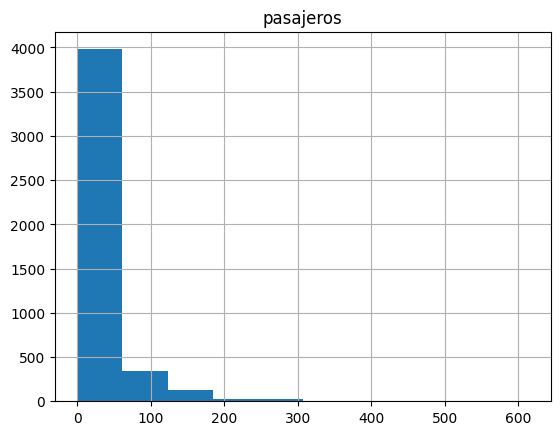

In [59]:
df.hist('pasajeros')
len(df)

El histograma de la variable del numero de pasajeros se ve muy desvalanceado, confirmando lo visto en el analisis general.
Voy a realizar dos histogramas mas filtrar los resultados para los casos con mas de 200 pasajeros y otro con los casos con menos de 50 pasajeros para observar mas de cerca.

array([[<Axes: title={'center': 'total_a_bordo'}>]], dtype=object)

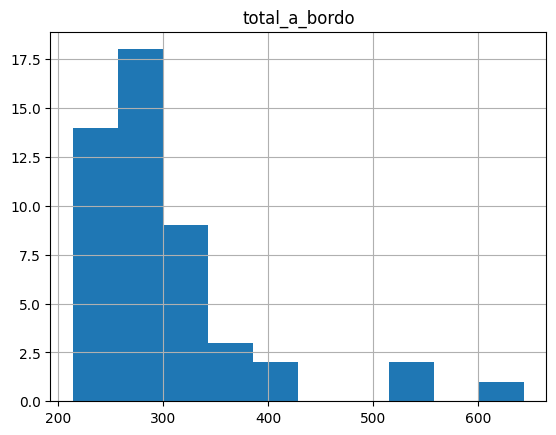

In [60]:
df.where(df['pasajeros'] > 200).hist('total_a_bordo')

array([[<Axes: title={'center': 'total_a_bordo'}>]], dtype=object)

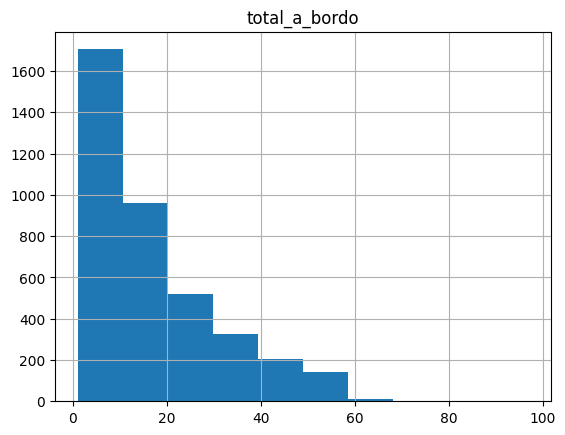

In [61]:
df.where(df['pasajeros'] <= 50).hist('total_a_bordo')

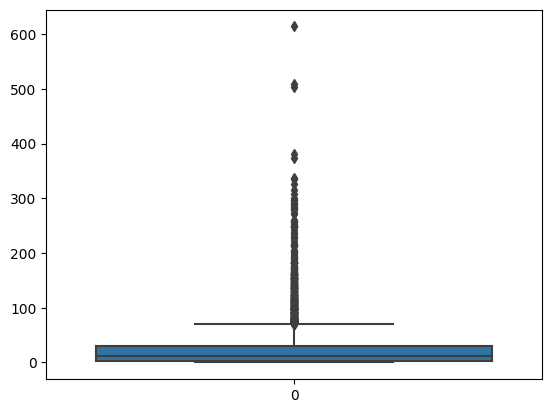

In [62]:
sns.boxplot(data=df['pasajeros'])
plt.show()

El boxplot y los histogramas de la cantidad de pasajeros confirman lo observado en la vision general. El numero de pasajeros es muy disperso y clasifica como outliers a muchos datos que son de interes. teniendo en cuenta los datos de mediana y cuartiles, crearemos una columna con un sistema de clasificacion por numero de pasajeros.

In [63]:
def clasif_pasajeros(nro_pasajeros):
    if nro_pasajeros <= 3:
        clasificacion = '3 o menos'
    elif nro_pasajeros <= 12:
        clasificacion = 'entre 3 y 12'
    elif nro_pasajeros <= 30:
        clasificacion = 'entre 12 y 30'
    elif nro_pasajeros <= 100:
        clasificacion = 'entre 30 y 100'
    else:
        clasificacion = 'mas de 100'
    
    return clasificacion

In [64]:
df['clasif_pasajeros'] = df.apply(lambda f: clasif_pasajeros(f['pasajeros']), axis=1)

array([[<Axes: title={'center': 'año'}>]], dtype=object)

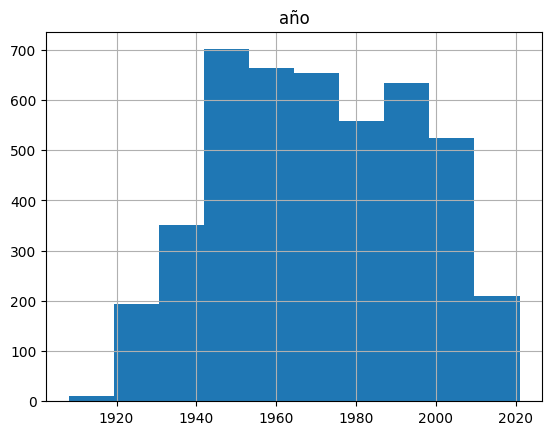

In [65]:
df.hist(['año'])

En cuanto a la distribucion por año, observamos que los casos estan mas concentrados entre las decadas de 1940 y 2010, habiendo una cantidad mas o menos relevante y equivalente para cada una de esas decadas.

array([[<Axes: title={'center': 'tripulacion'}>]], dtype=object)

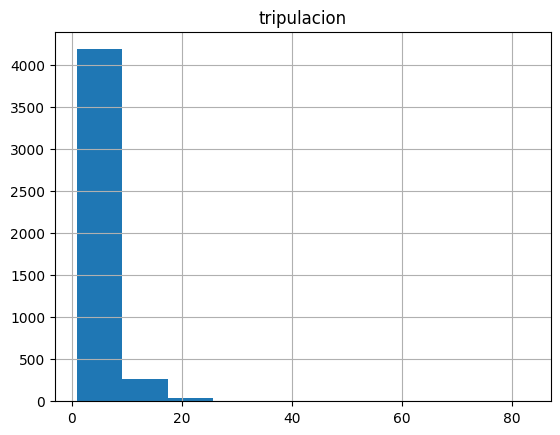

In [66]:
df.hist('tripulacion')

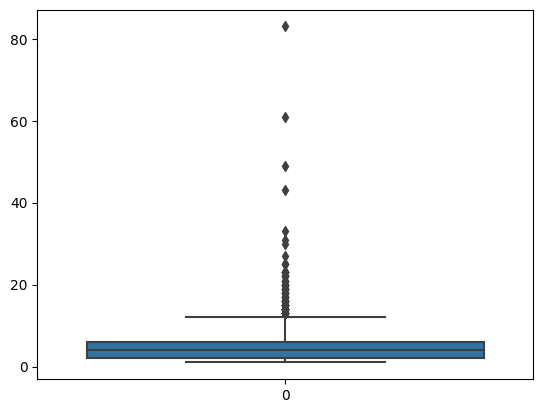

In [67]:
sns.boxplot(data=df['tripulacion'])
plt.show()

Similar a lo que ocurre con el numero de pasajeros, vemos que el numero de personas en la tripulacion esta mas fuertemente concentrado en los valores mas bajos. Pero, al ser los maximos mucho menores que los maximos de la columna pasajeros, el desvio estandar es considerablemente menor.

En todo caso, los valores absolutos tanto de tripulacion como de pasajeros brindan informacion incompleta, y tambien me interesaria ver la proporcion que representan respecto al numero de fallecidos. Por lo que creo las columnas:
- porcentaje de la tripulacion fallecidos: relacion entre numero de personas fallecidas de la tripulacion y numero total de tripulacion
- porcentaje de pasajeros fallecidos: relacion entre el numero de pasajeros fallecidos y numero total de pasajeros a bordo
- porcentaje total de fallecidos: relacion entre el numero total de personas fallecidas y el numero de personas a bordo
- relacion entre tripulacion y total: relacion entre el numero de personas de la tripulacion y el numero total de personas a bordo.

In [68]:
df['porc_tripulacion_fallecidos'] = df.apply(lambda f: f['tripulacion_fallecidos'] / f['tripulacion'], axis=1)
df['porc_pasajeros_fallecidos'] = df.apply(lambda f: f['pasajeros_fallecidos'] / f['pasajeros'] if f['pasajeros'] > 0 else np.nan, axis=1)
df['porc_total_fallecidos'] = df.apply(lambda f: f['total_fallecidos'] / f['total_a_bordo'], axis=1)
df['relacion_tripulacion_total'] = df.apply(lambda f: f['tripulacion'] / f['total_a_bordo'], axis=1)

Procedo a guardar las modificaciones realizadas en un CSV, exportando solo las columnas de interes.
Por otro lado, voy a crear un script de python solo con las lineas de codigo que representaron modificaciones a la base de datos original, para tener los pasos en limpio por fuera del analisis.

In [70]:
df = df[[
    'id', 'año', 'decada', 'total_a_bordo', 'clasif_pasajeros', 
    'porc_tripulacion_fallecidos', 'porc_pasajeros_fallecidos',
    'porc_total_fallecidos', 'relacion_tripulacion_total', 'total_fallecidos', 'tripulacion_fallecidos', 'pasajeros_fallecidos',
    'pasajeros', 'tripulacion', 'clima', 'pista'
]]

In [71]:
df.to_csv('procesado.csv')